In [18]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import utilities as u
import preprocessing as pp
import single_session_plots as ssp
import numpy as np
import SimilarityMatrixAnalysis as sm
import PlaceCellAnalysis as pc
import scipy as sp
import matplotlib.pyplot as plt
import h5py

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pp.load_session_db(twop_dir = "G:\\My Drive\\2P_Data\\Syt3KO")
# df = pp.load_session_db()
df = df[df['RewardCount']>20]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [3]:
mouse = '4343705.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
3066,4343705.1,13_01_2020,2,TwoTower_noTimeout,100,1,CA1,2020-01-13,G:\My Drive\VR_Data\TwoTower\4343705.1\13_01_2...,None,G:\My Drive\2P_Data\Syt3KO\4343705.1\13_01_202...,G:\My Drive\2P_Data\Syt3KO\4343705.1\13_01_202...
3094,4343705.1,15_01_2020,2,TwoTower_noTimeout,100,1,CA1,2020-01-15,G:\My Drive\VR_Data\TwoTower\4343705.1\15_01_2...,None,G:\My Drive\2P_Data\Syt3KO\4343705.1\15_01_202...,G:\My Drive\2P_Data\Syt3KO\4343705.1\15_01_202...


In [4]:
sess = df_mouse.iloc[-1]

In [7]:
print(sess['s2pfolder'])

G:\My Drive\2P_Data\Syt3KO\4343705.1\15_01_2020\TwoTower_noTimeout\TwoTower_noTimeout_002_004\suite2p


In [10]:
ops = np.load(os.path.join(sess['s2pfolder'],'plane0','ops.npy')).item()
for k,v in ops.items():
    print(k)

look_one_level_down
fast_disk
delete_bin
mesoscan
h5py
h5py_key
save_path0
save_folder
subfolders
nplanes
nchannels
functional_chan
tau
fs
force_sktiff
preclassify
save_mat
combined
aspect
do_bidiphase
bidiphase
do_registration
keep_movie_raw
nimg_init
batch_size
maxregshift
align_by_chan
reg_tif
reg_tif_chan2
subpixel
smooth_sigma
th_badframes
pad_fft
nonrigid
block_size
snr_thresh
maxregshiftNR
1Preg
spatial_hp
pre_smooth
spatial_taper
roidetect
sparse_mode
diameter
spatial_scale
connected
nbinned
max_iterations
threshold_scaling
max_overlap
high_pass
inner_neuropil_radius
min_neuropil_pixels
allow_overlap
chan2_thres
baseline
win_baseline
sig_baseline
prctile_baseline
neucoeff
xrange
yrange
data_path
save_path
ops_path
reg_file
reg_file_chan2
meanImg
meanImg_chan2
nframes
Ly
Lx
yblock
xblock
nblocks
NRsm
refImg
yoff
xoff
corrXY
yoff1
xoff1
corrXY1
badframes
regPC
regDX
tPC
max_proj
Lyc
Lxc
Vmap
Vcorr
spatscale_pix
Vmax
ihop
Vsplit
meanImgE


In [12]:
rc = np.load(os.path.join(sess['s2pfolder'],'plane0','redcell.npy'))

In [33]:
basedir,_ = os.path.split(os.path.split(sess['scanmat'])[0])
predir = os.path.join(basedir,'pre')
redstack_fname = os.path.join(predir,'pre_001_001_chan1.h5')
with h5py.File(redstack_fname,'r') as f:
    redimg = f['data'][11,:,:]


In [34]:
print(basedir)

G:\My Drive\2P_Data\Syt3KO\4343705.1\15_01_2020


In [35]:
ops['meanImg_chan2']=redimg

696 512


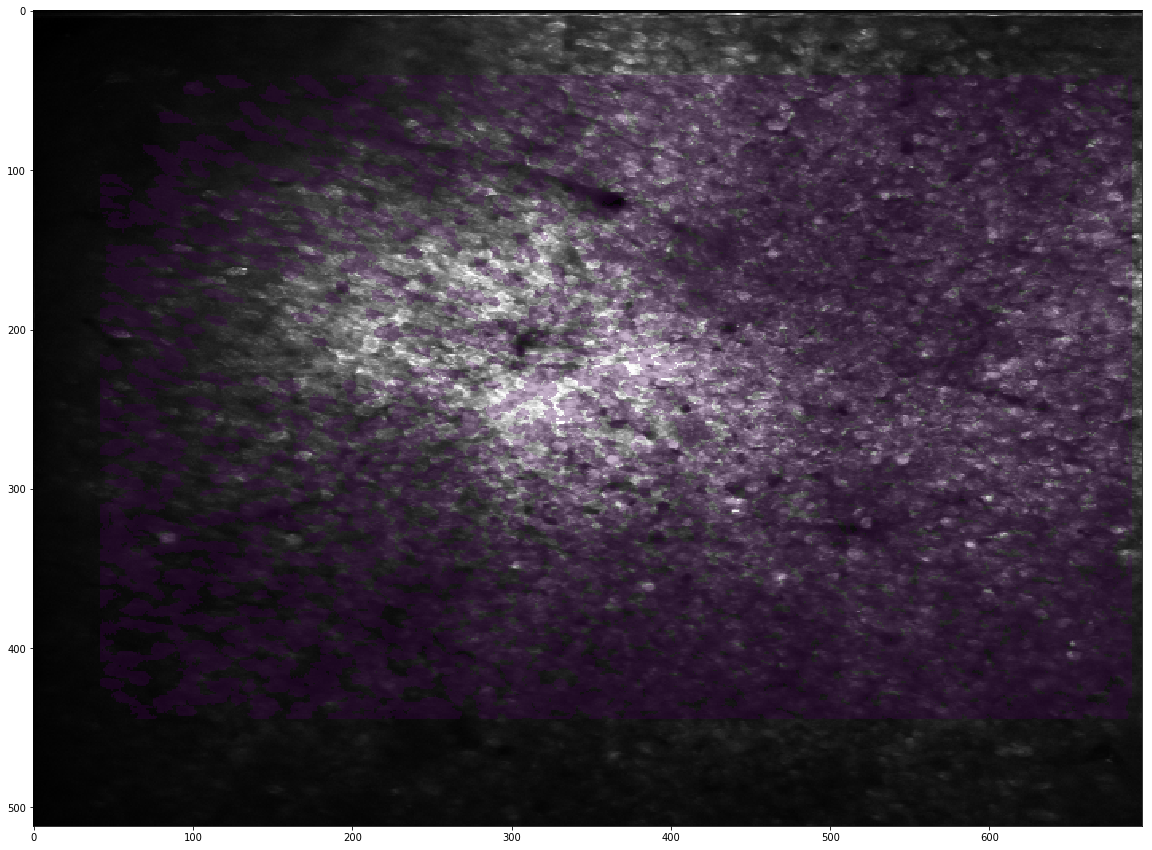

In [36]:
f,ax = plt.subplots(figsize=[20,15])
ax.imshow(redimg,cmap='gray')

print(ops['Lx'],ops['Ly'])
# load stat file
stat = np.load(os.path.join(sess['s2pfolder'],'plane0','stat.npy'))


# plot ROIs

roi_im = np.zeros((ops['Ly'], ops['Lx']))
roi_im[:]=np.nan

for n in range(0,len(stat)):
    ypix = stat[n]['ypix']
    xpix = stat[n]['xpix']
    roi_im[ypix,xpix] = 1

ax.imshow(roi_im,alpha=.3)
# plt.imshow(im)
# plt.show()



In [30]:
# load aligned data
VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=.7,analysis='s2p')

# S/=1546
S = S/np.percentile(S,95,axis=0)[np.newaxis,:]
S[np.isnan(S)]=0.
C[np.isnan(C)]=0.

# get trial by trial info
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,
                                            VRDat['pos']._values,VRDat['tstart']._values,
                                            VRDat['teleport']._values,bin_size=10,
                                            speed = VRDat['speed']._values)
effMorph = trial_info['morphs']+trial_info['wallJitter']+trial_info['bckgndJitter']+trial_info['towerJitter']#+.3)/1.6
    
# calculate place cells


masks, FR, SI = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                        VRDat['tstart']._values, VRDat['teleport']._values,
                        method='bootstrap',correct_only=False,speed=VRDat.speed._values,
                        win_trial_perm=True,morphlist=np.unique(trial_info['morphs']).tolist())

num aberrant ttls 0.0
58539 (58539,) (58539, 21) 81824
(81824,) (81824, 21)
8.534487114704396 1893.1265790803436
0.0 1893.0934815563417


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0
start bootstrap
end bootstrap


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:119: RuntimeWarning: Mean of empty slice
  frmap[i] = np.nanmean(C[(position>edge1) & (position<=edge2),:],axis=0)


start bootstrap
end bootstrap


696 512


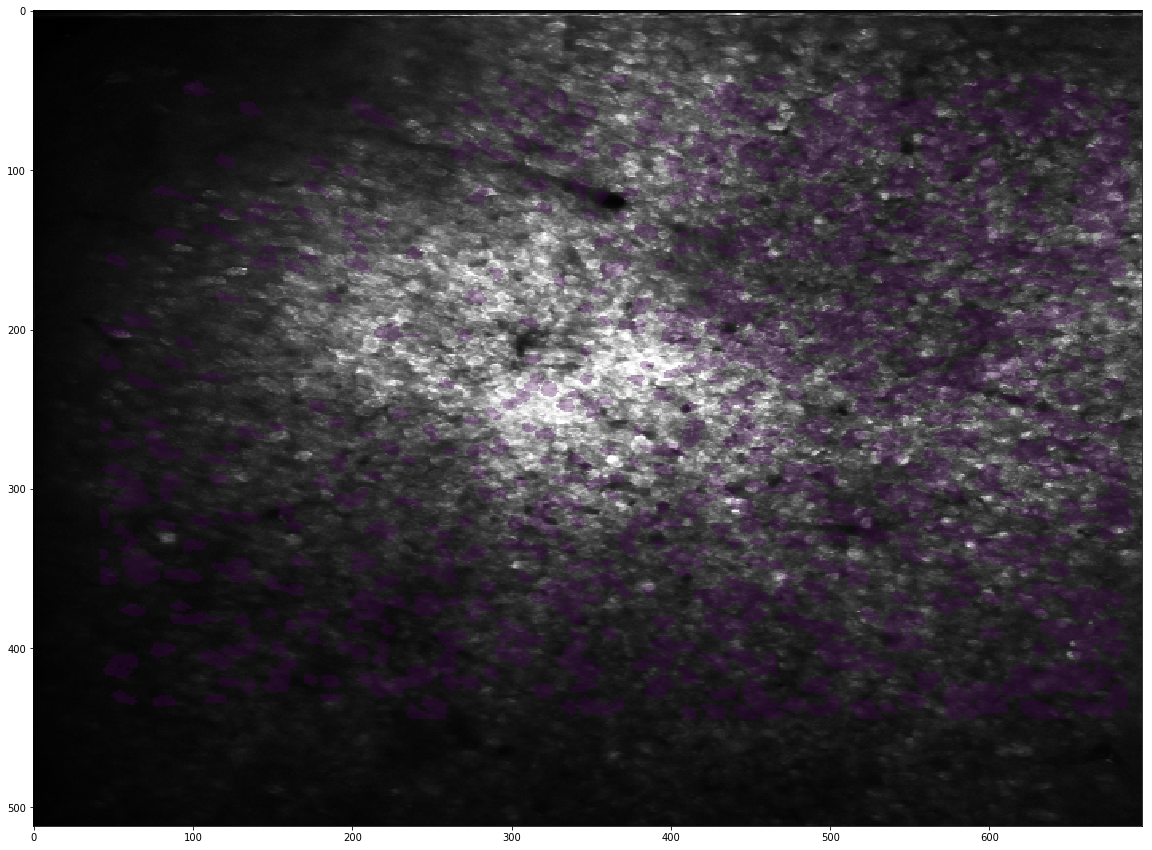

In [37]:
# plot ROIs on red image filtering by place cells

f,ax = plt.subplots(figsize=[20,15])
ax.imshow(redimg,cmap='gray')
Mask = masks[0]|masks[1]
print(ops['Lx'],ops['Ly'])

iscell = np.load(os.path.join(sess['s2pfolder'],'plane0','iscell.npy'))
stat_cells = stat[iscell[:,0]>0]
stat_pc = stat_cells[Mask]

# plot ROIs

roi_im = np.zeros((ops['Ly'], ops['Lx']))
roi_im[:]=np.nan

for n in range(0,len(stat_pc)):
    ypix = stat_pc[n]['ypix']
    xpix = stat_pc[n]['xpix']
    roi_im[ypix,xpix] = 1

ax.imshow(roi_im,alpha=.3)

In [38]:
f.savefig("G:\\My Drive\\2P_Data\\Syt3KO\\PlaceCellFootprintsOnMCherryBckgnd.png",format='png')